# Energy A.I. Hackathon 2026 Workflow - Energ-AI-z

#### Authors: 
Abraham Montes, Department of Petroleum Engineering<br>
Chris Lopez, Department of Aerospace Engineering<br>
Dalma Cerro, Department of Petroleum Engineering<br>
Joao Brandao, Department of Engineering Management<br>
Simón Montoya-Bedoya, Department of Mechanical Engineering


#### The University of Texas at Austin, Austin, Texas, USA 
___

### Executive Summary 

Only 4 short sentences.

1. What is the problem?

2. What did your team do to address the problem?

3. What did your team learn?

4. What does your team recommend going forward?

___

### Workflow Goal

1-2 sentences 
___

### Workflow Steps 

Enumerated steps, very short and concise overview of your methods and workflow

1. **Data Analysis** - basic data checking and visualization
2. **Feature Selection** - mutual information-based approach with minimum redundancy, maximum relevance score
3. **Machine Learning Model \#1** - Predict feature $X$ from $Y,Z$

$\ldots$


In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import seaborn as sb
from scipy.stats import kurtosis, skew, spearmanr
from scipy.linalg import norm, lstsq
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D
from scipy.stats import mode

We start our workflow by loading the historical production data to get insights about its behavior 

/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_3566/3304098284.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});
/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_3566/3304098284.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});
/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_3566/3304098284.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});
/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_3566/330

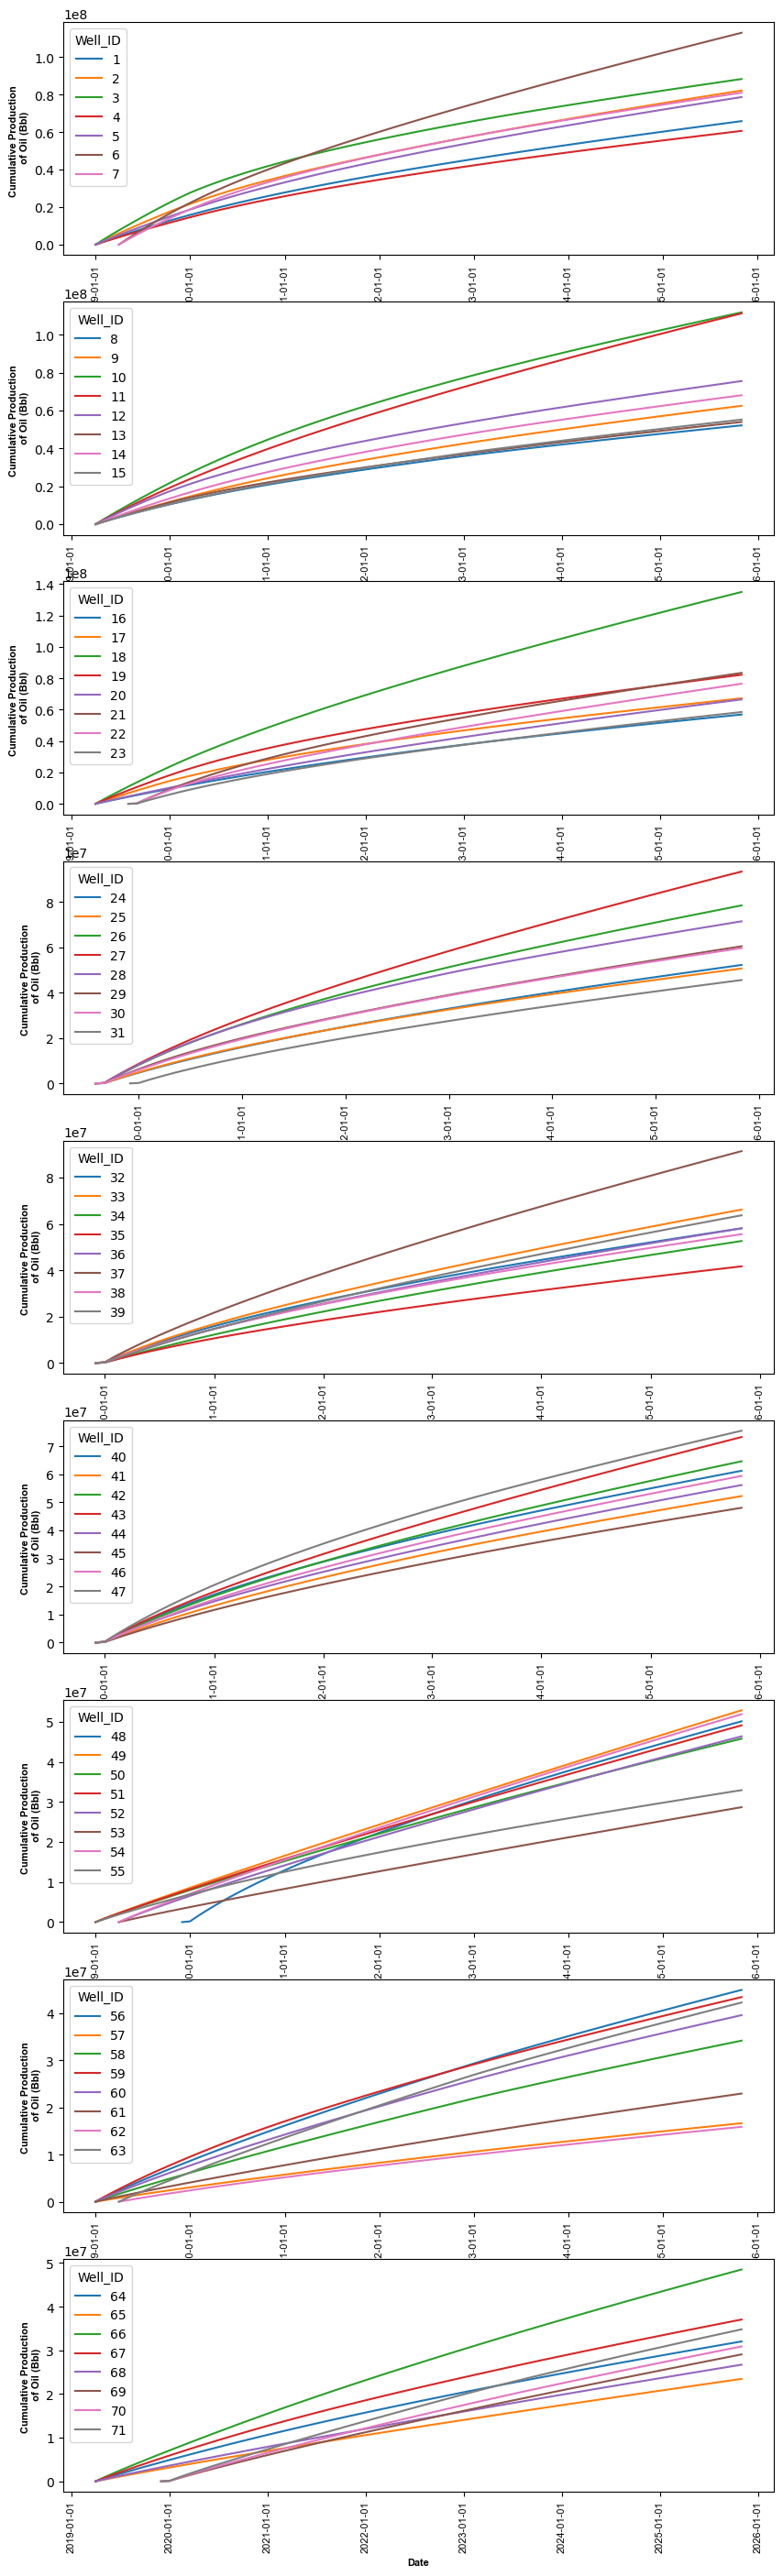

In [2]:
# Defining dataset to train our models and do our predictions
# Definig dataframe to work with
historic_production_data = pd.read_csv( "production.csv",parse_dates=["Date"] )
fig,ax = plt.subplots( 9,1,figsize=(10,35) )

# Plotting cumulative production for some wells
for i in range(9):
    wellidx     = i*8
    sb.lineplot( data=historic_production_data[(historic_production_data["Well_ID"]>=wellidx) & (historic_production_data["Well_ID"]<=wellidx+7)], x="Date",
                 y="Cumulative Oil Production, BBL",
                 hue="Well_ID",palette="tab10",ax=ax[i] )
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[i].set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
    ax[i].set_xlabel( "Date",fontdict={"family":"Arial","size":8,"weight":"bold"} )
    ax[i].set_xticklabels(ax[i].get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

In [3]:
# Observing unique well ids in the dataset
np.unique(historic_production_data["Well_ID"])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71])

/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_3566/117343385.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8})


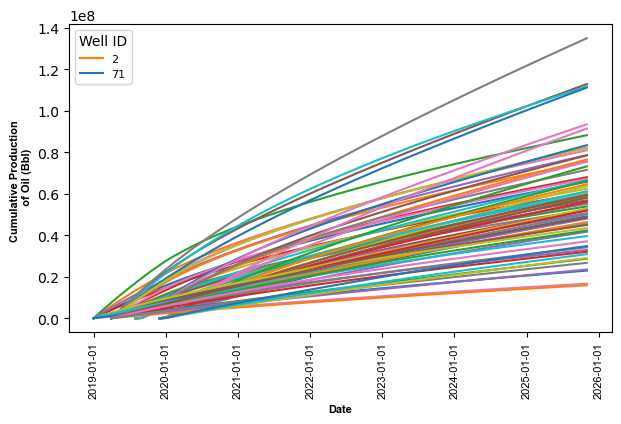

In [4]:
# Stuyding the cumulative production for all wells in a single plot
fig,ax = plt.subplots( figsize=(7,4 ) )
sb.lineplot( data=historic_production_data, x="Date",
                 y="Cumulative Oil Production, BBL",
                 hue="Well_ID",palette="tab10",ax=ax )
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Date",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8})
# Put just legend for 1st and last well
handles, labels = ax.get_legend_handles_labels()
ax.legend( handles=[handles[1],handles[-1]], labels=[labels[1],labels[-1]], title="Well ID",title_fontsize=10,fontsize=8 )

In [ ]:
# Defining features to work with
dflogs = pd.read_csv("logs.csv")

dflogs_imp = pd.read_csv("well_log_production_imputed_subset.csv")

# Concat dflogs with dflogs_imp to fill missing values
dflogs = pd.concat( [dflogs,dflogs_imp],axis=0 )
 
# Creating empty columns to fill with features calculated from well logs
historic_production_data["gamma_var"] = 0
historic_production_data["gamma_skew"] = 0
historic_production_data["months"] = 0
historic_production_data["mean_por"] = 0
historic_production_data["mean_perm"] = 0
historic_production_data["kurt_perm"] = 0
historic_production_data["neighbor_density_25"] = 0
historic_production_data["neighbor_density_70"] = 0
historic_production_data["X"] = 0
historic_production_data["Y"] = 0
historic_production_data["cumulative_3y"] = 0
historic_production_data["gamma_mean"] = 0
historic_production_data["facies_p75"] = 0
historic_production_data["z_mean"] = 0
historic_production_data["acoustic_imp"] = 0
historic_production_data["kophi_sqrt_of_means"] = 0
historic_production_data["kophi_mean_of_sqrts"] = 0

def calculate_well_density( xvals,yvals,allx,ally,allIDs,quantile ):
    x   = xvals[0]
    y   = yvals[0]
    ids = np.unique( allIDs )
    dists = [  ]
    for id in ids:
        idxs=np.argwhere( allIDs==id )
        xs  = allx[idxs][0]
        ys  = ally[idxs][0]
        if x!=xs and y!=ys:
            dists.append( 1/norm( np.array([x-xs,y-ys]) ) )
    return np.min( dists )

for id in np.unique(dflogs["Well_ID"]):
    historic_production_data["mean_por"] = 0
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"X"] = np.unique( dflogs[dflogs["Well_ID"]==id]["X"] )[0]
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"Y"] = np.unique( dflogs[dflogs["Well_ID"]==id]["Y"] )[0]
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"gamma_var"] = np.std( dflogs[dflogs["Well_ID"]==id]["GR"] )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"acoustic_imp"] = np.mean( dflogs[dflogs["Well_ID"]==id]["AI_imp"] )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"kophi_mean_of_sqrts"] = ( np.mean( np.sqrt(dflogs[dflogs["Well_ID"]==id]["perm_imp"]/dflogs[dflogs["Well_ID"]==id]["phi_imp"] ) ) )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"z_mean"] = np.mean( dflogs[dflogs["Well_ID"]==id]["Z"] )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"gamma_mean"] = np.mean( dflogs[dflogs["Well_ID"]==id]["GR"] )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"facies_p75"] = np.quantile( dflogs[dflogs["Well_ID"]==id]["facies"],0.75 )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"gamma_skew"] = skew( dflogs[dflogs["Well_ID"]==id]["GR"].values )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"mean_por"] = np.mean( dflogs[dflogs["Well_ID"]==id]["phi_imp"] )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"mean_perm"] = np.mean( dflogs[dflogs["Well_ID"]==id]["perm_imp"] )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"kurt_perm"] = kurtosis( dflogs[dflogs["Well_ID"]==id]["perm_imp"].values )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"neighbor_density_25"] = calculate_well_density( dflogs[dflogs["Well_ID"]==id]["X"].values,dflogs[dflogs["Well_ID"]==id]["Y"].values,
                                                                           dflogs["X"].values,dflogs["Y"].values,dflogs["Well_ID"],0.25 )
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"neighbor_density_70"] = calculate_well_density( dflogs[dflogs["Well_ID"]==id]["X"].values,dflogs[dflogs["Well_ID"]==id]["Y"].values,
                                                                           dflogs["X"].values,dflogs["Y"].values,dflogs["Well_ID"],0.7 )
    historic_production_data.loc[historic_production_data["Well_ID"] == id, "months"] = (
        historic_production_data.loc[historic_production_data["Well_ID"] == id, "Date"]
        - historic_production_data.loc[historic_production_data["Well_ID"] == id, "Date"].min(  )
    ).dt.days
    monthsWell          = historic_production_data[historic_production_data["Well_ID"]==id]["months"] - 36
    prodWell          = historic_production_data[historic_production_data["Well_ID"]==id]["Cumulative Oil Production, BBL"]
    historic_production_data.loc[historic_production_data["Well_ID"]==id,"cumulative_3y"] = np.min( prodWell[monthsWell>0] )
    
historic_production_data["months"]=historic_production_data["months"]/30

# Getting a feeling og the dataset with new features
historic_production_data

/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_3566/715167496.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '12.61655934299265' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  historic_production_data.loc[historic_production_data["Well_ID"]==id,"gamma_var"] = np.std( dflogs[dflogs["Well_ID"]==id]["GR"] )
/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_3566/715167496.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5023633.198529412' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  historic_production_data.loc[historic_production_data["Well_ID"]==id,"acoustic_imp"] = np.mean( dflogs[dflogs["Well_ID"]==id]["AI"] )
/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_3566/715167496.py:47: FutureWarning: Sett

,Well_ID,Date,"Cumulative Gas Production, ft3","Cumulative Oil Production, BBL","Cumulative Water Production, BBL",gamma_var,gamma_skew,months,mean_por,mean_perm,...,neighbor_density_70,X,Y,cumulative_3y,gamma_mean,facies_p75,z_mean,acoustic_imp,kophi_sqrt_of_means,kophi_mean_of_sqrts
0,1,2019-01-01,0.000000e+00,0.00,0.000000e+00,12.616559,NaN,0.000000,0.00000,905.733337,...,0.005692,33,127,2882681.25,34.50313,NaN,29.184211,5.023633e+06,0,55.443503
1,1,2019-02-01,1.981249e+09,1560038.50,4.634771e+04,12.616559,NaN,1.033333,0.00000,905.733337,...,0.005692,33,127,2882681.25,34.50313,NaN,29.184211,5.023633e+06,0,55.443503
2,1,2019-03-01,3.661006e+09,2882681.25,8.738335e+04,12.616559,NaN,1.966667,0.00000,905.733337,...,0.005692,33,127,2882681.25,34.50313,NaN,29.184211,5.023633e+06,0,55.443503
3,1,2019-04-01,5.474707e+09,4310793.00,1.334990e+05,12.616559,NaN,3.000000,0.00000,905.733337,...,0.005692,33,127,2882681.25,34.50313,NaN,29.184211,5.023633e+06,0,55.443503
4,1,2019-05-01,7.194637e+09,5665069.00,1.791346e+05,12.616559,NaN,4.000000,0.00000,905.733337,...,0.005692,33,127,2882681.25,34.50313,NaN,29.184211,5.023633e+06,0,55.443503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5512,71,2025-07-01,4.209285e+10,33143974.00,2.761039e+06,27.173784,NaN,67.966667,0.19215,510.576594,...,0.005708,151,166,812823.00,58.07322,4.0,30.400000,5.828308e+06,0,46.236874
5513,71,2025-08-01,4.262622e+10,33563956.00,2.809077e+06,27.173784,NaN,69.000000,0.19215,510.576594,...,0.005708,151,166,812823.00,58.07322,4.0,30.400000,5.828308e+06,0,46.236874
5514,71,2025-09-01,4.315820e+10,33982832.00,2.857320e+06,27.173784,NaN,70.033333,0.19215,510.576594,...,0.005708,151,166,812823.00,58.07322,4.0,30.400000,5.828308e+06,0,46.236874
5515,71,2025-10-01,4.367173e+10,34387188.00,2.904204e+06,27.173784,NaN,71.033333,0.19215,510.576594,...,0.005708,151,166,812823.00,58.07322,4.0,30.400000,5.828308e+06,0,46.236874


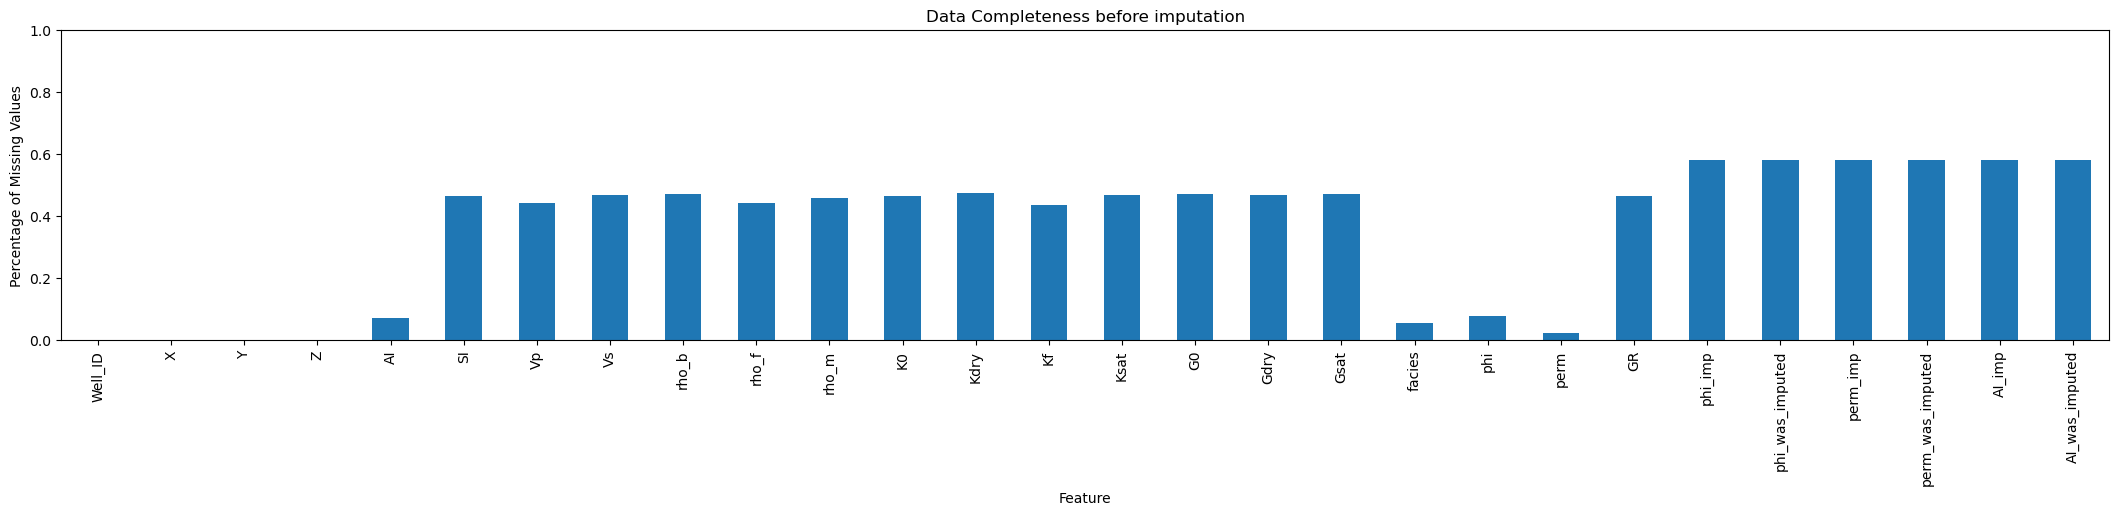

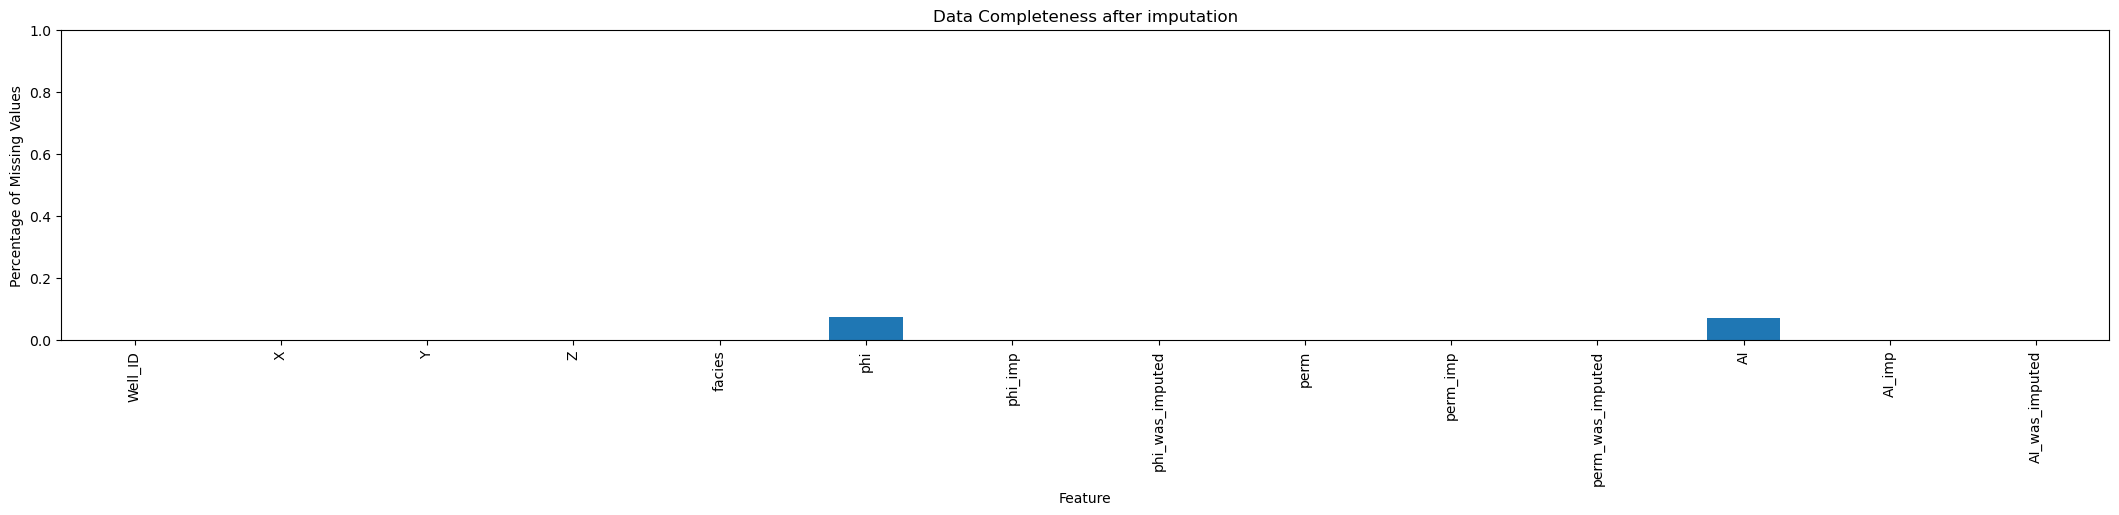

In [6]:
# Let's take a look to the data before and after imputing missing values
# Plotting data completeness before and after imputation
plt.subplot(311)
(dflogs.isnull().sum()/len(dflogs)).plot(kind = 'bar')          # calculate DataFrame with percentage missing by feature
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Values'); plt.title('Data Completeness before imputation'); plt.ylim([0.0,1.0])
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=2.2, wspace=0.2, hspace=0.2) # plot formatting
plt.show()

plt.subplot(311)
(dflogs_imp.isnull().sum()/len(dflogs_imp)).plot(kind = 'bar')          # calculate DataFrame with percentage missing by feature
plt.xlabel('Feature'); plt.ylabel('Percentage of Missing Values'); plt.title('Data Completeness after imputation'); plt.ylim([0.0,1.0])
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.2, top=2.2, wspace=0.2, hspace=0.2) # plot formatting
plt.show()

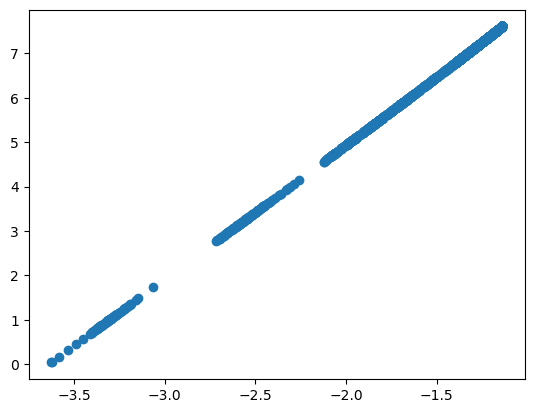

In [7]:
# Exploring the relationship between porosity and permeability
plt.scatter( np.log( dflogs["phi"] ),np.log(dflogs["perm"]) )

/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_3566/3821693220.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


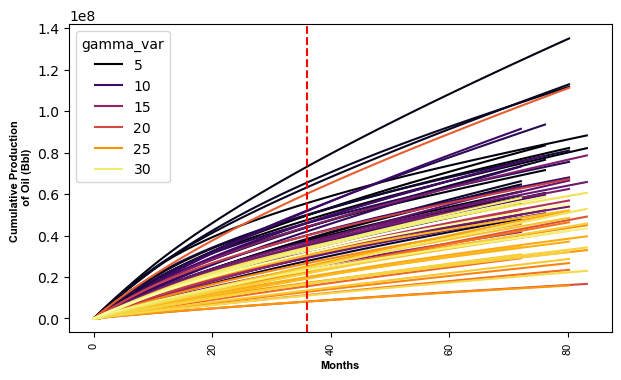

In [8]:
# Exploring the relationship of the cumulative production with gamma ray variance
fig,ax = plt.subplots( figsize=(7,4 ) )
sb.lineplot( data=historic_production_data, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="gamma_var",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_3566/3150424080.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


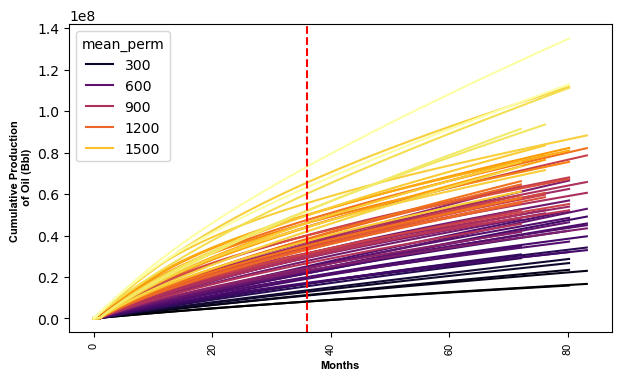

In [9]:
# Exploring the relationship of the cumulative production with gamma ray variance
fig,ax = plt.subplots( figsize=(7,4 ) )
sb.lineplot( data=historic_production_data, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="mean_perm",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_3566/1747015170.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});


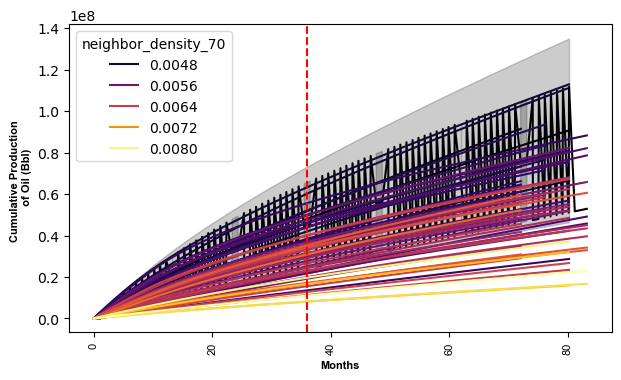

In [10]:
# Exploring the relationship of the cumulative production with neighbor density
fig,ax = plt.subplots( figsize=(7,4 ) )
sb.lineplot( data=historic_production_data, x="months",
                 y="Cumulative Oil Production, BBL",
                 hue="neighbor_density_70",palette="inferno",ax=ax )

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_ylabel( "Cumulative Production \n of Oil (Bbl)",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.set_xlabel( "Months",fontdict={"family":"Arial","size":8,"weight":"bold"} )
ax.axvline(x=36,color="red",ls="--")
ax.set_xticklabels(ax.get_xticklabels(  ),rotation=90,fontdict={"family":"Arial","size":8});

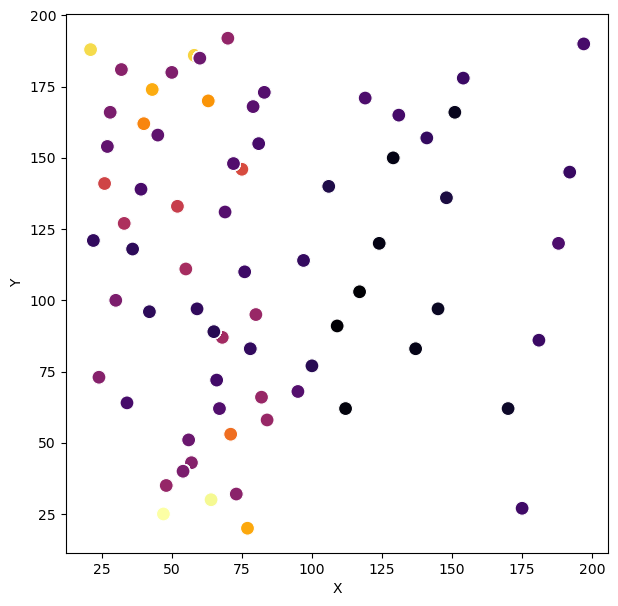

In [11]:
fig,ax = plt.subplots( figsize=(7,7) )
sb.scatterplot( data=historic_production_data,x="X",y="Y",hue="cumulative_3y",palette="inferno",ax=ax,s=100 );
ax.legend().remove()

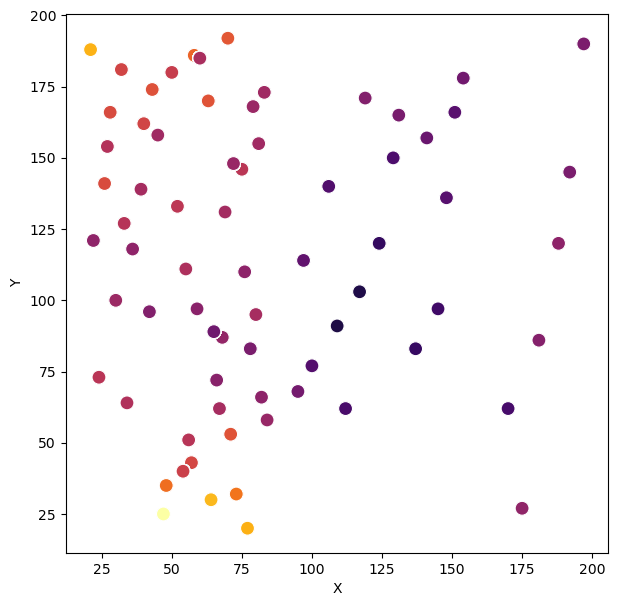

In [12]:
fig,ax = plt.subplots( figsize=(7,7) )
sb.scatterplot( data=historic_production_data,x="X",y="Y",hue="Cumulative Oil Production, BBL",palette="inferno",ax=ax,s=100 );
ax.legend().remove()

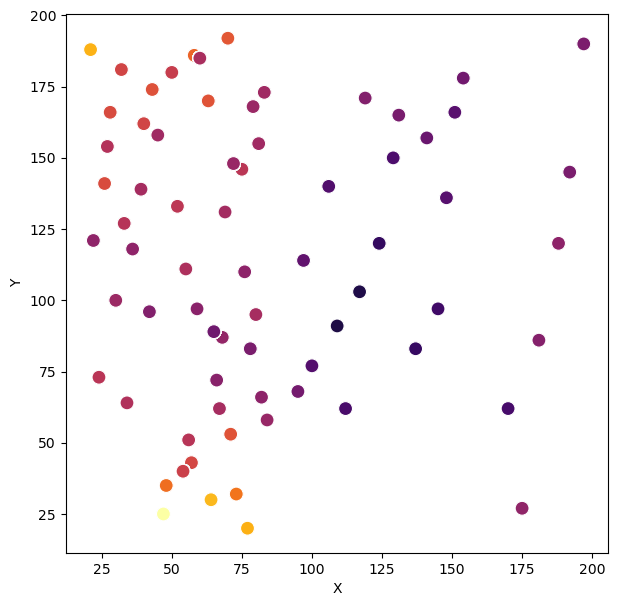

In [13]:
fig,ax = plt.subplots( figsize=(7,7) )
sb.scatterplot( data=historic_production_data,x="X",y="Y",hue="Cumulative Oil Production, BBL",palette="inferno",ax=ax,s=100 );
ax.legend().remove()

In [14]:
# Extracting first value from unique well IDs since we will it out with features already calculated
df_out = historic_production_data.groupby("Well_ID", as_index=False).first( )
df_out.head(  )

,Well_ID,Date,"Cumulative Gas Production, ft3","Cumulative Oil Production, BBL","Cumulative Water Production, BBL",gamma_var,gamma_skew,months,mean_por,mean_perm,...,neighbor_density_70,X,Y,cumulative_3y,gamma_mean,facies_p75,z_mean,acoustic_imp,kophi_sqrt_of_means,kophi_mean_of_sqrts
0,1,2019-01-01,0.0,0.0,0.0,12.616559,NaN,0.0,0.0,905.733337,...,0.005692,33,127,2882681.25,34.503130,NaN,29.184211,5.023633e+06,0,55.443503
1,2,2019-01-01,0.0,0.0,0.0,5.077962,NaN,0.0,0.0,1240.585071,...,0.005373,71,53,3972052.50,28.114431,NaN,28.975000,4.396773e+06,0,65.302806
2,3,2019-01-01,0.0,0.0,0.0,5.404112,NaN,0.0,0.0,1549.900744,...,0.005066,58,186,5067011.00,26.777932,NaN,28.875000,3.976039e+06,0,71.536720
3,4,2019-01-01,0.0,0.0,0.0,29.342676,NaN,0.0,0.0,888.934841,...,0.006635,80,95,2633379.50,44.726999,NaN,29.971429,4.972358e+06,0,53.988171
4,5,2019-01-01,0.0,0.0,0.0,14.133232,NaN,0.0,0.0,1017.066077,...,0.005330,26,141,3362580.50,31.695926,NaN,28.947368,4.701052e+06,0,60.219577


In [15]:
# Extracting all property names from the dataframe
# Need to delete unnecesary columns
propertiesNames = df_out.columns.tolist()


df_out = df_out[["gamma_var","gamma_mean","mean_por","mean_perm","neighbor_density_25","neighbor_density_70","facies_p75","Y","X","acoustic_imp","kophi_mean_of_sqrts","Well_ID","cumulative_3y"]]



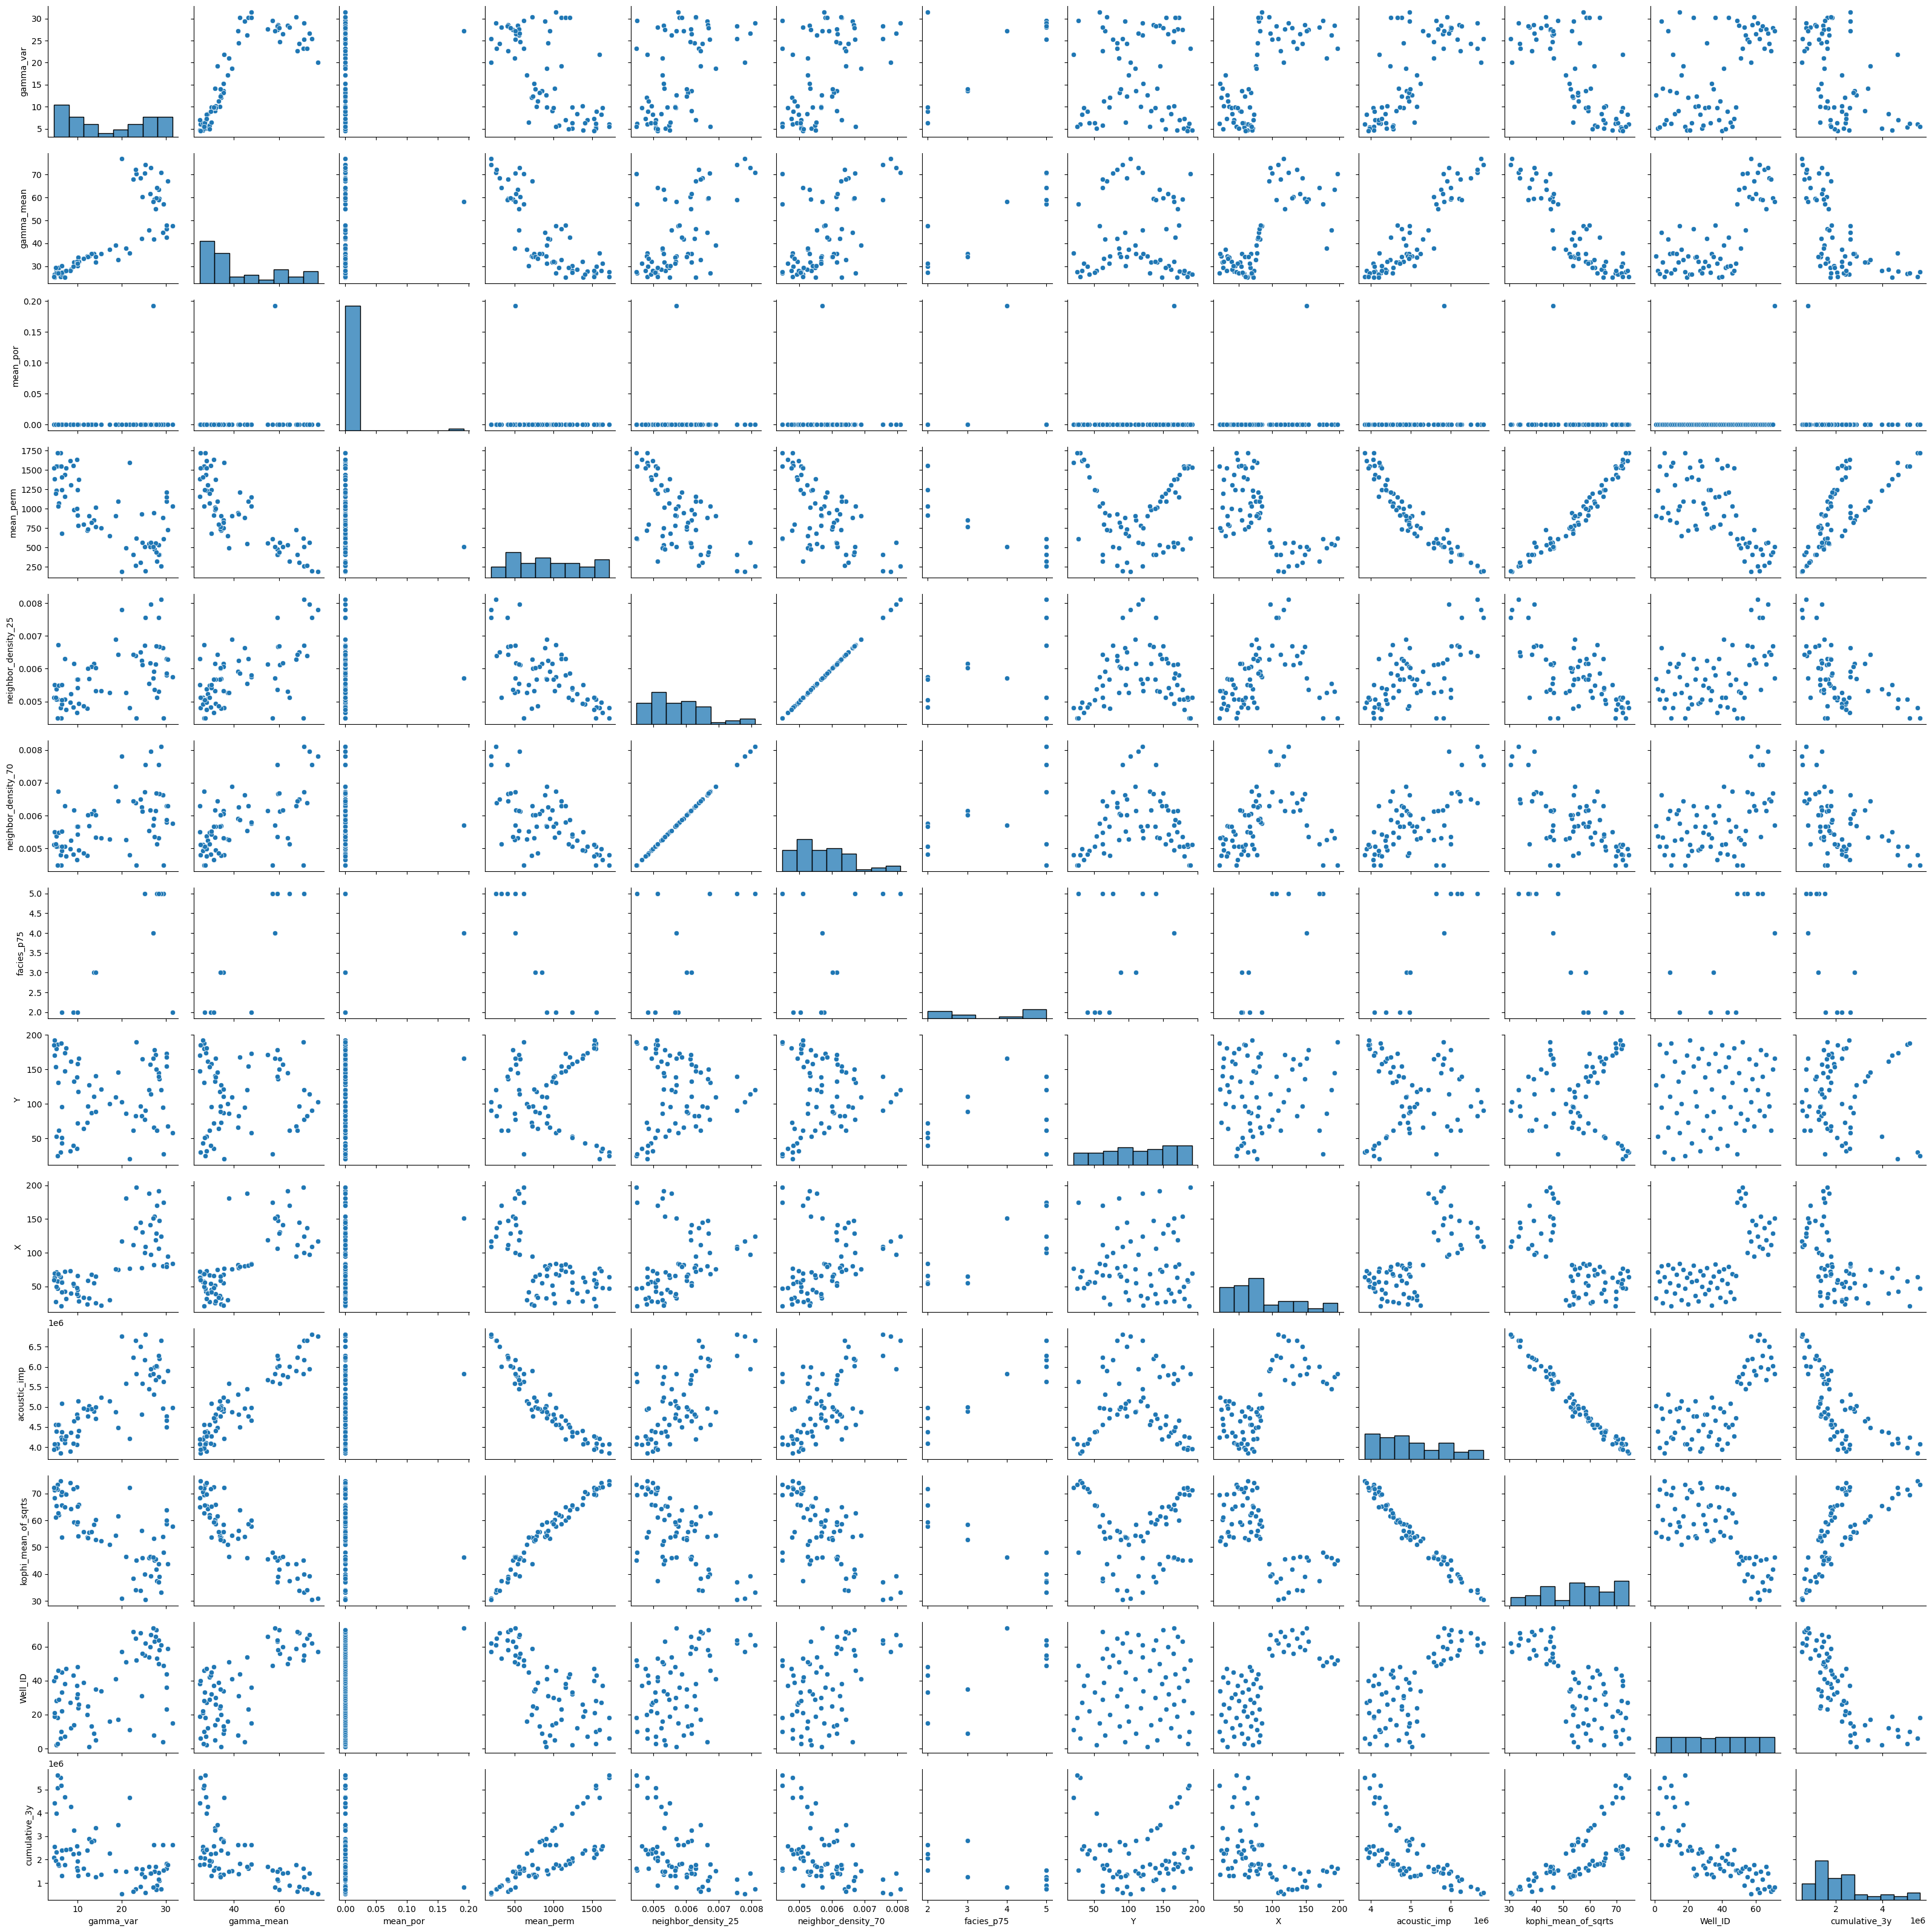

In [16]:
sb.pairplot(df_out)

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

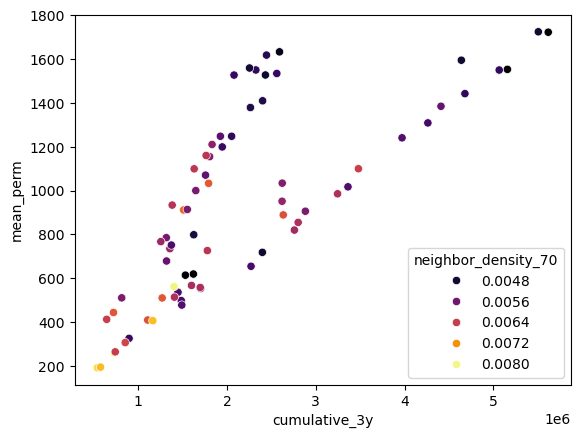

In [17]:
df_out["is_crowded"] = np.where(df_out["neighbor_density_70"]>0.006,1,0)
# sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="is_crowded",palette="inferno" )
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="neighbor_density_70",palette="inferno" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

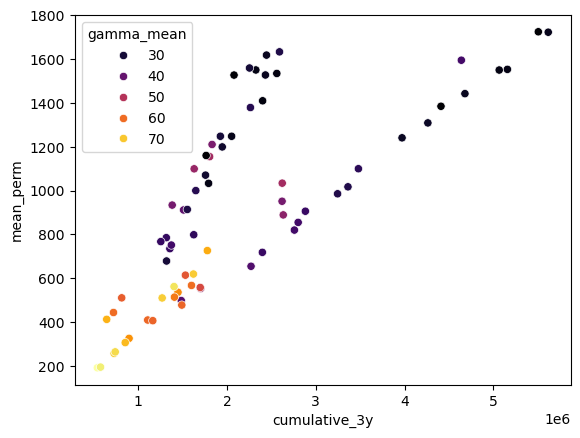

In [18]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="gamma_mean",palette="inferno" )

In [19]:
# Inlcuding other features calculated related to facies and mechanical properties
df_mechanical = pd.read_csv("mechanical.csv" )
df_facies = pd.read_csv("facies.csv")
df_times = pd.read_csv( "times.csv",parse_dates=["earliest"] )

# Facies-related features
df_out["facies_percentage"] = df_facies["Percentage_Facies_3_or_Less"]

# Mechanical properties-related features
df_out["brittleness"] = df_mechanical["Mean_Brittleness_Index"]
df_out["young"] = df_mechanical["Mean_Youngs_Modulus_Velocities"]
df_out["poisson"] = df_mechanical["Mean_Poisson_Ratio_Velocities"]

# Calculating other features to explore their relationship with cumulative production
df_out["porosity_permeability"] = df_out["mean_por"]/df_out["mean_perm"]
df_out["porosity_times_permeability"] = df_out["mean_por"]
# Permeability considering percentage of sands
df_out["perm_over_facies"] = np.where(df_out["facies_percentage"]> 0, df_out["mean_perm"]/df_out["facies_percentage"], 0)

# Using time-related features to see how early or late a well was drilled
df_times["is_before_cutoff_2"] = np.where( df_times["earliest"]<pd.to_datetime( "2019-08-01",format="%Y-%m-%d" ),1,0 )
df_out["well_on"] = np.where(df_times["is_before_cutoff_2"],"early","late")

df_out.head(  )

,gamma_var,gamma_mean,mean_por,mean_perm,neighbor_density_25,neighbor_density_70,facies_p75,Y,X,acoustic_imp,...,cumulative_3y,is_crowded,facies_percentage,brittleness,young,poisson,porosity_permeability,porosity_times_permeability,perm_over_facies,well_on
0,12.616559,34.503130,0.0,905.733337,0.005692,0.005692,NaN,127,33,5.023633e+06,...,2882681.25,0,84.210526,0.316659,6.073266,0.360807,0.0,0.0,10.755583,early
1,5.077962,28.114431,0.0,1240.585071,0.005373,0.005373,NaN,53,71,4.396773e+06,...,3972052.50,0,100.000000,0.295761,5.905293,0.353756,0.0,0.0,12.405851,early
2,5.404112,26.777932,0.0,1549.900744,0.005066,0.005066,NaN,186,58,3.976039e+06,...,5067011.00,0,100.000000,0.217135,5.829404,0.366579,0.0,0.0,15.499007,early
3,29.342676,44.726999,0.0,888.934841,0.006635,0.006635,NaN,95,80,4.972358e+06,...,2633379.50,1,73.684211,0.356151,6.313622,0.368558,0.0,0.0,12.064116,early
4,14.133232,31.695926,0.0,1017.066077,0.005330,0.005330,NaN,141,26,4.701052e+06,...,3362580.50,0,94.117647,0.321841,6.060783,0.358462,0.0,0.0,10.806327,early


<Axes: xlabel='mean_perm', ylabel='cumulative_3y'>

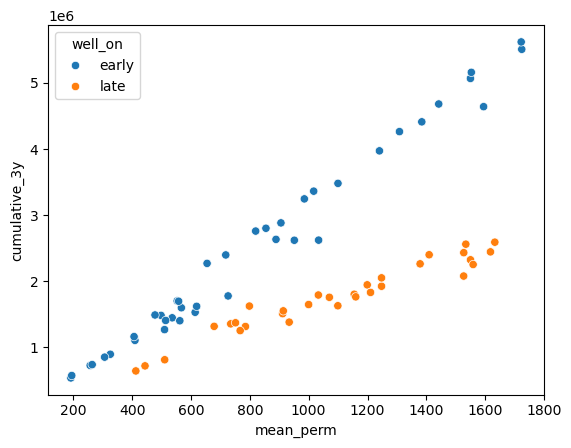

In [20]:
# Plotting cumulative response vs permeability colored by time well was drilled
sb.scatterplot( data=df_out,y="cumulative_3y",x="mean_perm",hue="well_on",palette="tab10" )


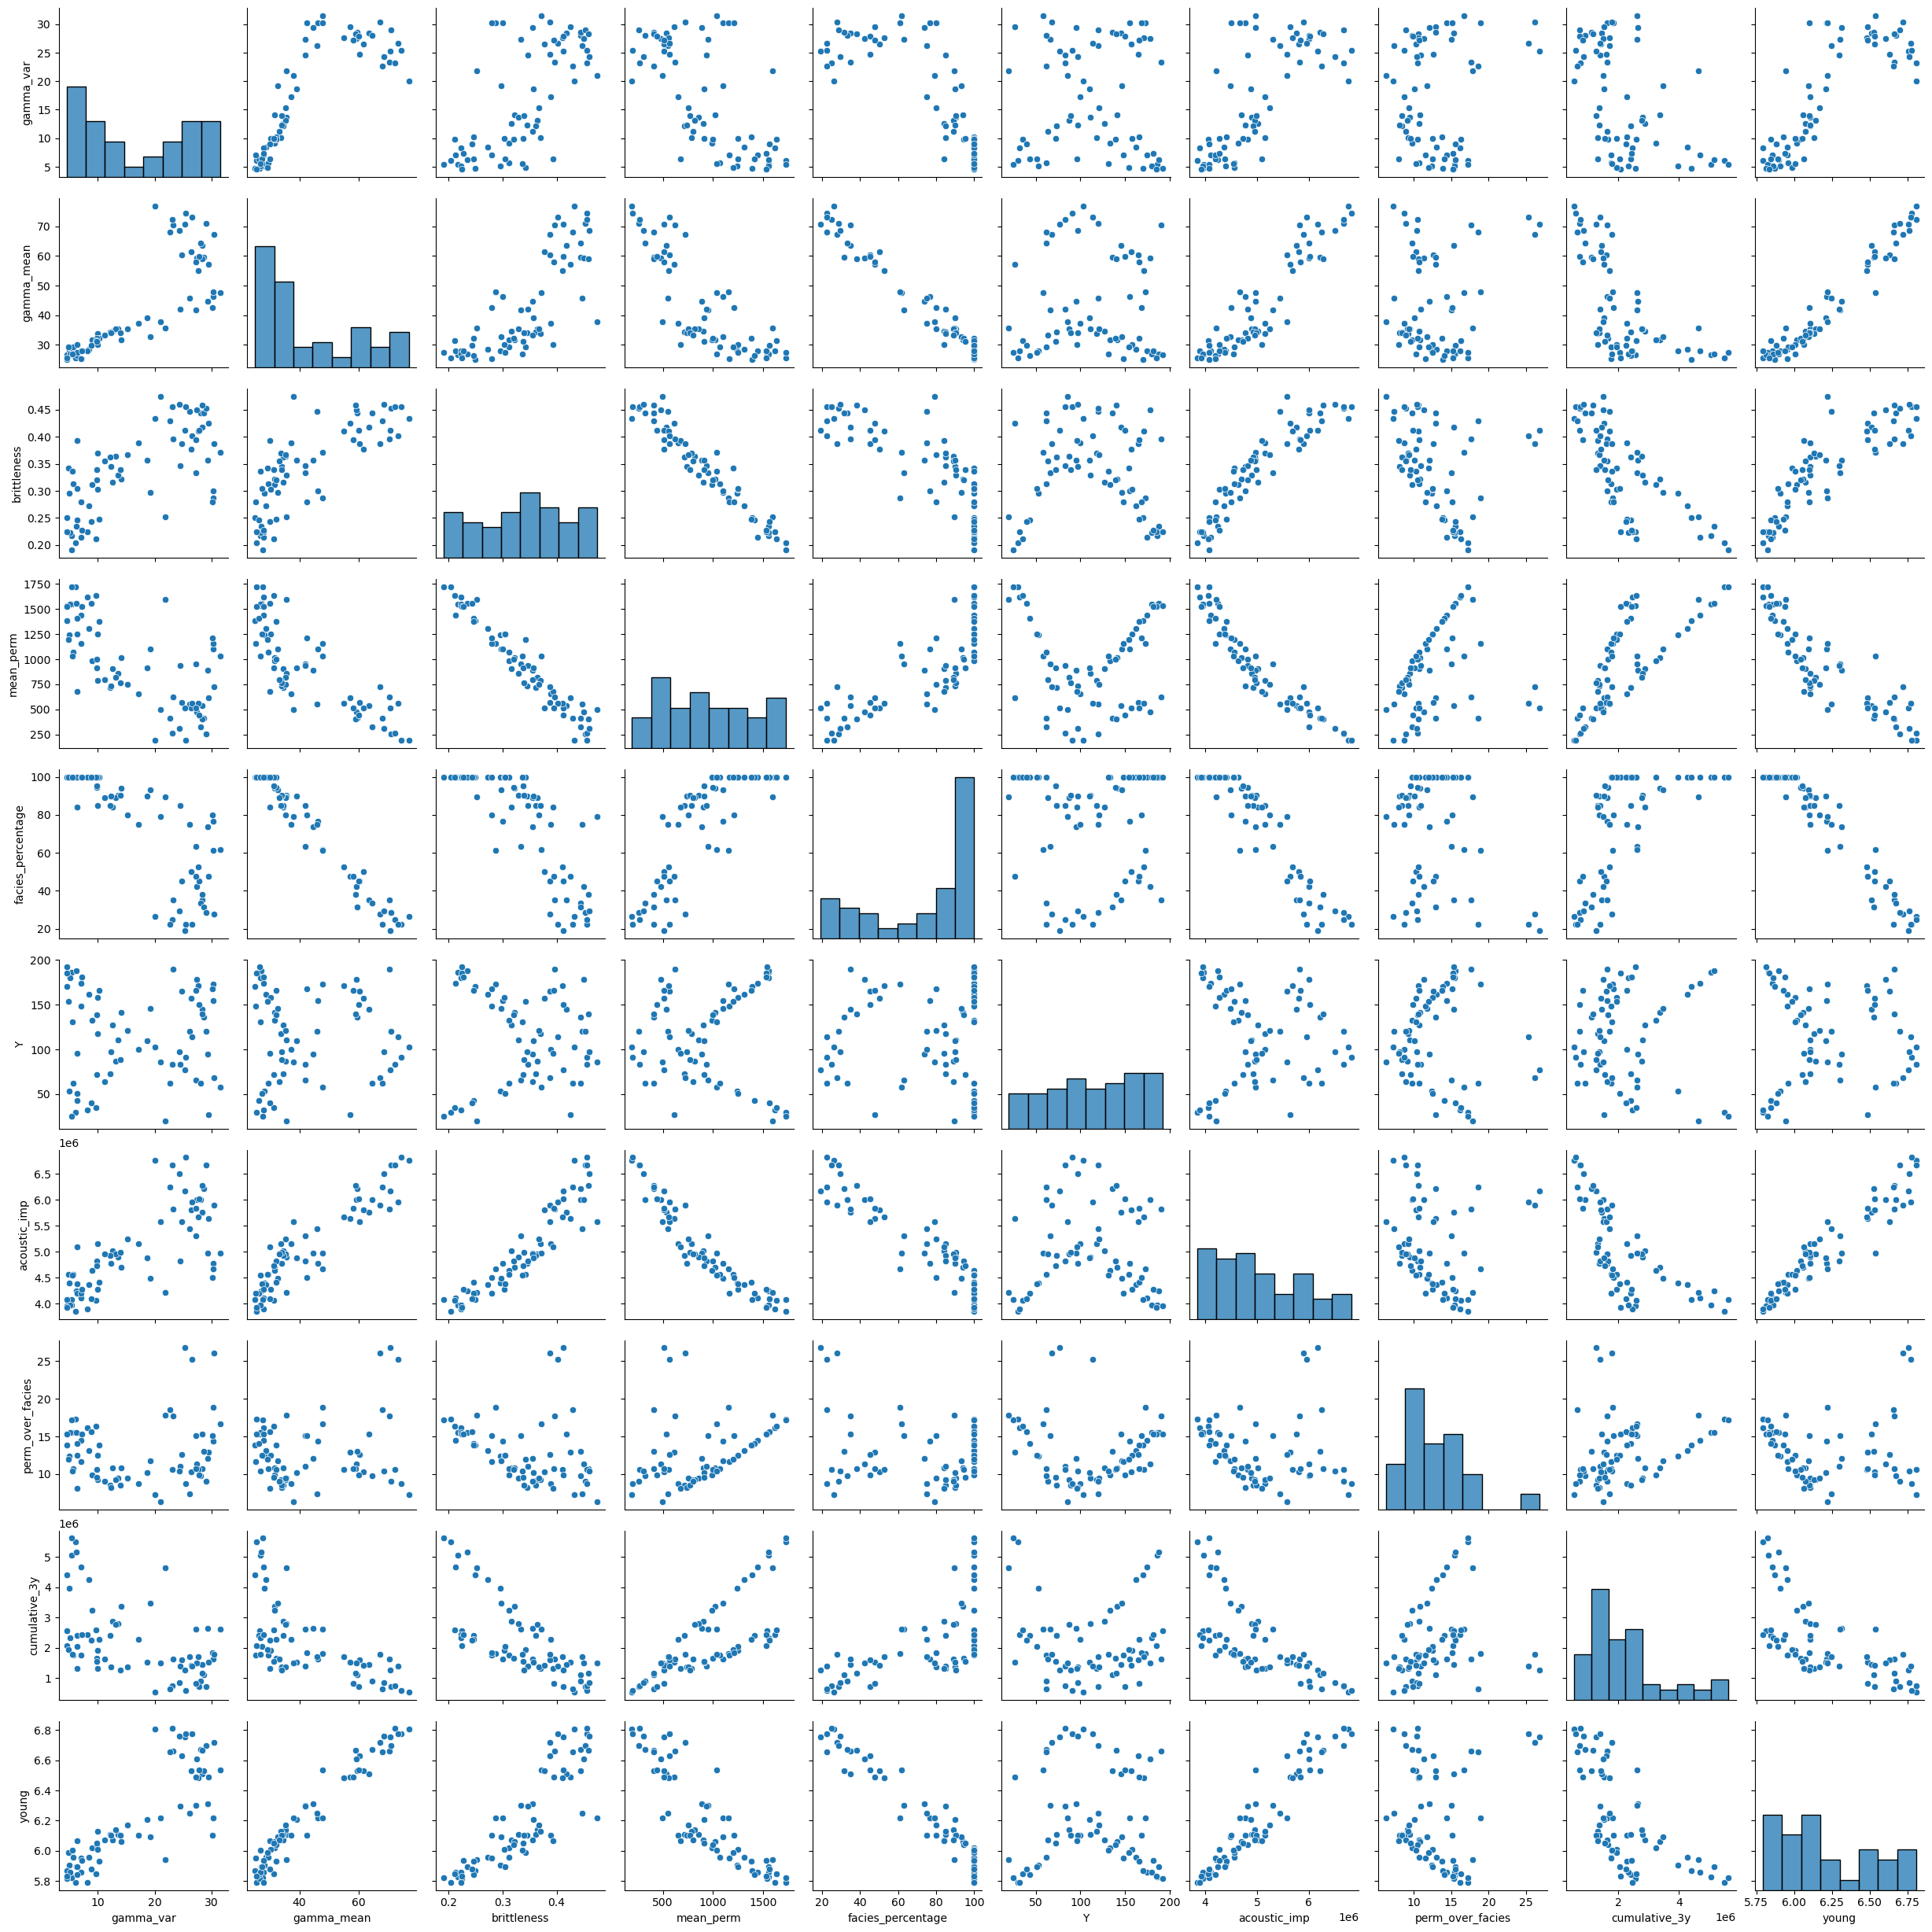

In [21]:
# Testing correlations between features and target against cumulative production using pairplot
df_out = df_out[["gamma_var","gamma_mean","brittleness","mean_perm","facies_percentage","Y","well_on","acoustic_imp","perm_over_facies","cumulative_3y","young"]]

sb.pairplot(df_out)

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

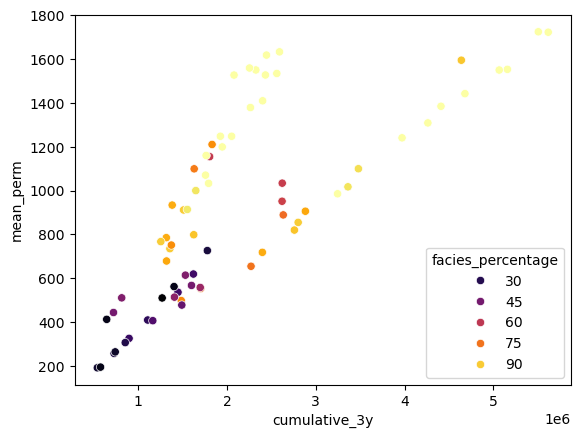

In [22]:
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="facies_percentage",palette="inferno" )

<Axes: xlabel='cumulative_3y', ylabel='mean_perm'>

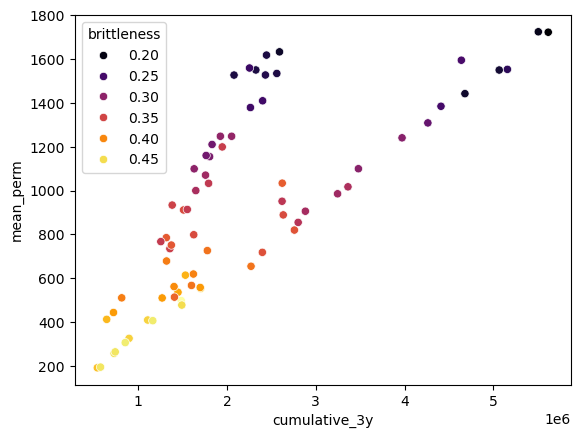

In [23]:
# CReate a scatter plot to see relationship between cumulative production and permeability colored by brittleness with gradient color
sb.scatterplot( data=df_out,x="cumulative_3y",y="mean_perm",hue="brittleness",palette="inferno" )

## Training Model with Only Late Wells

/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_3566/2484556113.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["is_facie_2"] = np.where( df_train["facies_percentage"]<75,1,0 )
/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_3566/2484556113.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["logperm"] = np.log( df_train["mean_perm"] )


<Axes: xlabel='logperm', ylabel='cumulative_3y'>

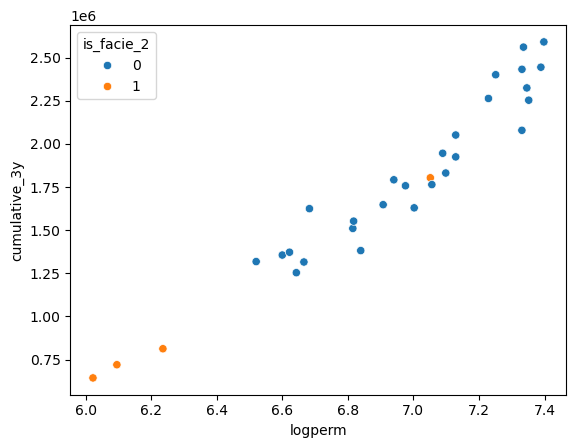

In [24]:
df_train = df_out[df_out["well_on"]=="late"]
df_train["is_facie_2"] = np.where( df_train["facies_percentage"]<75,1,0 )
df_train["logperm"] = np.log( df_train["mean_perm"] )
sb.scatterplot( data=df_train,x="logperm",y="cumulative_3y",hue="is_facie_2",palette="tab10" )

In [25]:
df_train.head(  )

,gamma_var,gamma_mean,brittleness,mean_perm,facies_percentage,Y,well_on,acoustic_imp,perm_over_facies,cumulative_3y,young,is_facie_2,logperm
20,4.665723,26.566998,0.224981,1534.243523,100.000000,192,late,3.949336e+06,15.342435,2560803.000,5.815694,0,7.335793
21,6.373737,26.424559,0.246787,1409.566245,100.000000,43,late,4.199274e+06,14.095662,2400820.250,5.844842,0,7.251037
22,30.250608,46.268357,0.300602,1099.181976,76.470588,155,late,4.772501e+06,14.373918,1629373.500,6.216952,0,7.002322
23,10.044680,33.846909,0.369460,785.110024,85.000000,118,late,5.145973e+06,9.236589,1315493.125,6.128699,0,6.665824
24,12.307833,34.124102,0.344717,734.993962,90.000000,97,late,4.774758e+06,8.166600,1355874.875,6.103678,0,6.599862


### Testing with SVR

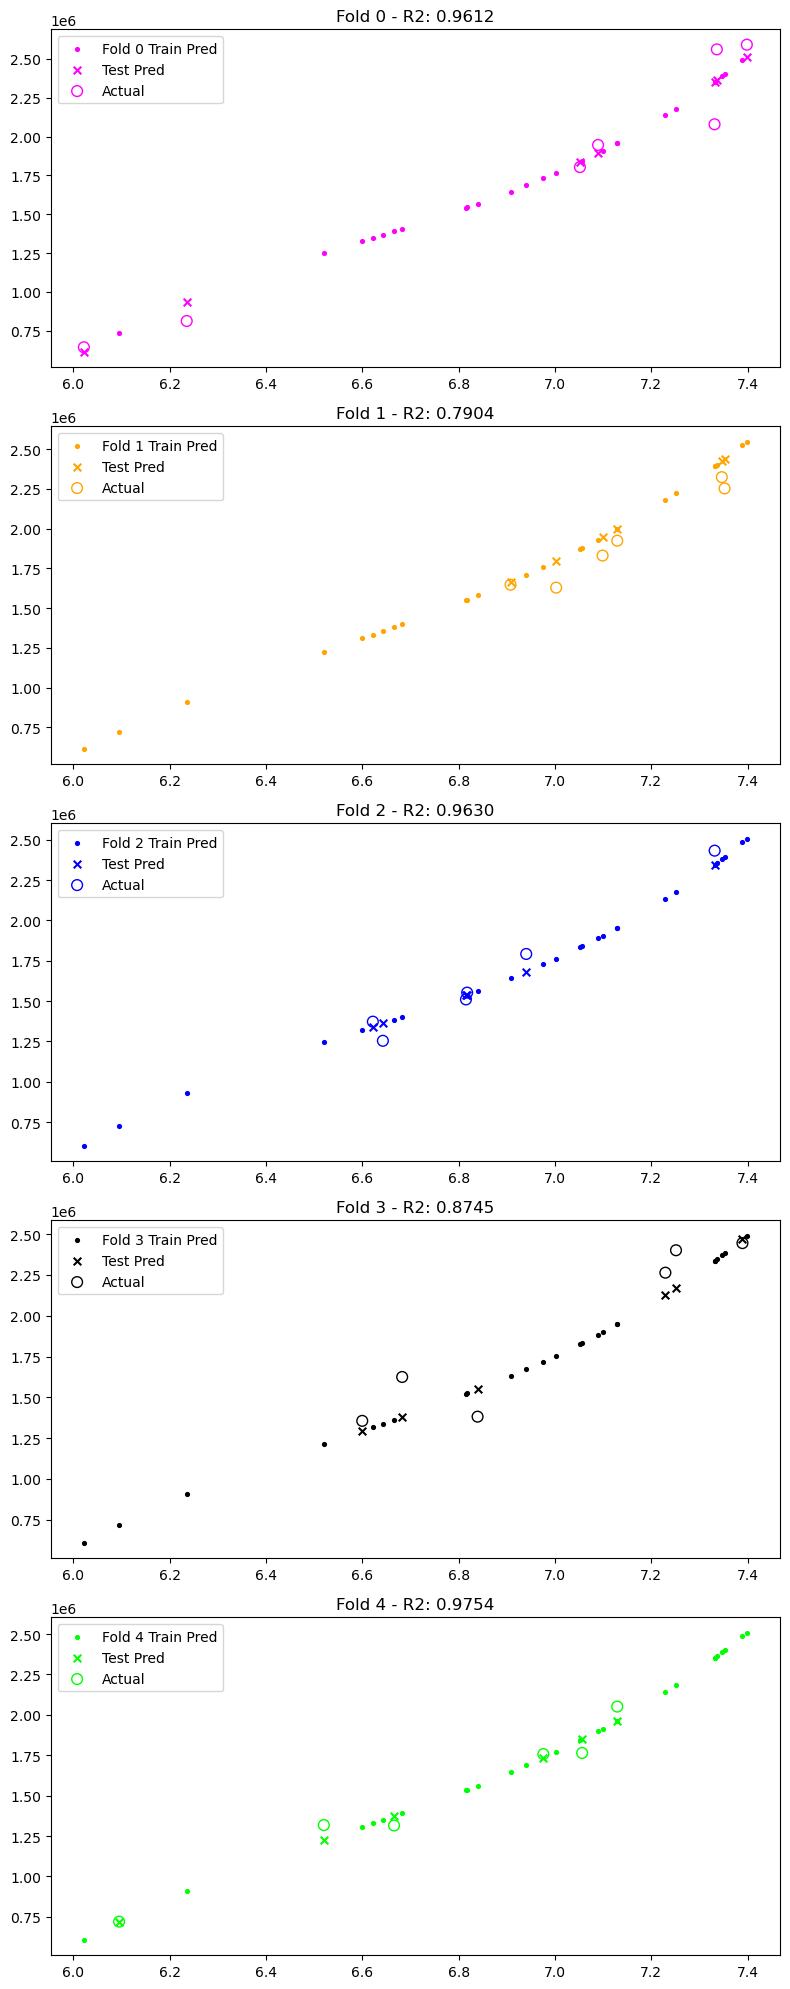

Average R2 Score: 0.9129
R2 Scores per fold: [0.9611826761399203, 0.7904305022638558, 0.9629845658274221, 0.8744732304097176, 0.975370932802993]


In [26]:
# Prepare Data (X can be multiple input colums)
# Example: X = df_train[["logperm", "porosity", "depth"]].values
# X = df_train[["logperm","acoustic_imp"]].values
X = df_train[["logperm"]].values 
y = df_train["cumulative_3y"].values

kf = KFold(n_splits=5, shuffle=True)
r2scores = []
cols = ["magenta", "orange", "blue", "black", "lime"]

fig, ax = plt.subplots(5, 1, figsize=(8, 20))

for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Define the Pipeline
    # Moving PolynomialFeatures inside the pipeline is cleaner for multi-variable X
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=3, include_bias=True)),
        #('model', SVR(kernel='rbf', C=50, gamma=0.1)) # Adjust C and gamma as needed
        ('model', Lasso())
    ])
    
    # Split data 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit and Predict
    pipe.fit(X_train, y_train)
    ypred = pipe.predict(X_test)
    ytrainpreds = pipe.predict(X_train)

    # Visualization
    # Note: For plotting, we use X_train[:, 0] to represent the first feature on the x-axis
    ax[i].scatter(X_train[:, 0], ytrainpreds, color=cols[i], lw=1.5, label=f"Fold {i} Train Pred", s=5)
    ax[i].scatter(X_test[:, 0], ypred, marker="x", s=30, color=cols[i], label="Test Pred")
    ax[i].scatter(X_test[:, 0], y_test, marker="o", s=60, edgecolors=cols[i], facecolors='None', label="Actual")

    score = r2_score(y_test, ypred)
    r2scores.append(score)
    ax[i].set_title(f"Fold {i} - R2: {score:.4f}")
    ax[i].legend()

plt.tight_layout()
plt.show()

print(f"Average R2 Score: {sum(r2scores)/len(r2scores):.4f}")
print("R2 Scores per fold:", r2scores)

## Uncertainty Model

In [27]:
## Uncertainty Model
realizations_per_sample = {  }
for i in range(df_train.shape[0]):
    withold_point = df_train.iloc[i,:]
    x_wh = withold_point["logperm"].reshape(-1,1)
    y_hw = withold_point["cumulative_3y"]
    new_df      = pd.concat( [df_train.iloc[0:i,:],df_train.iloc[i+1:,:]] )
    X           = new_df["logperm"].values
    y           = new_df["cumulative_3y"].values
    realizations_per_sample[ i ] = { "actual":y_hw,"reals":[  ] }
    for j in range(100):
        degree_rand = np.random.randint( 3 )   
        model_type_rand =  0#np.random.randint( 0,4 ) 
        model_types = [LinearRegression(  ),Ridge(  ),Lasso(  ),Ridge(  ),RandomForestRegressor(  ), AdaBoostRegressor(  ),LinearRegression(  )]
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.80 )
        model = model_types[model_type_rand]
        pipe = Pipeline( [('scaler', StandardScaler(  )), ('model', model)] )
        if model_type_rand<=1:
            poly=PolynomialFeatures(degree=degree_rand,include_bias=True)
            poly_features=poly.fit_transform(X_train.reshape(-1,1))
            poly_test=poly.transform( x_wh.reshape(-1,1) )
            pipe.fit(poly_features, y_train)
            # ypred = pipe.predict( poly_test )
            # ytrainpreds = pipe.predict( poly_features )
            ywhp = pipe.predict( poly_test )[0]
        else:
            pipe.fit(X_train.reshape(-1,1), y_train)
            ywhp = pipe.predict( x_wh )[0]
        
        
        realizations_per_sample[ i ]["reals"].append( ywhp )


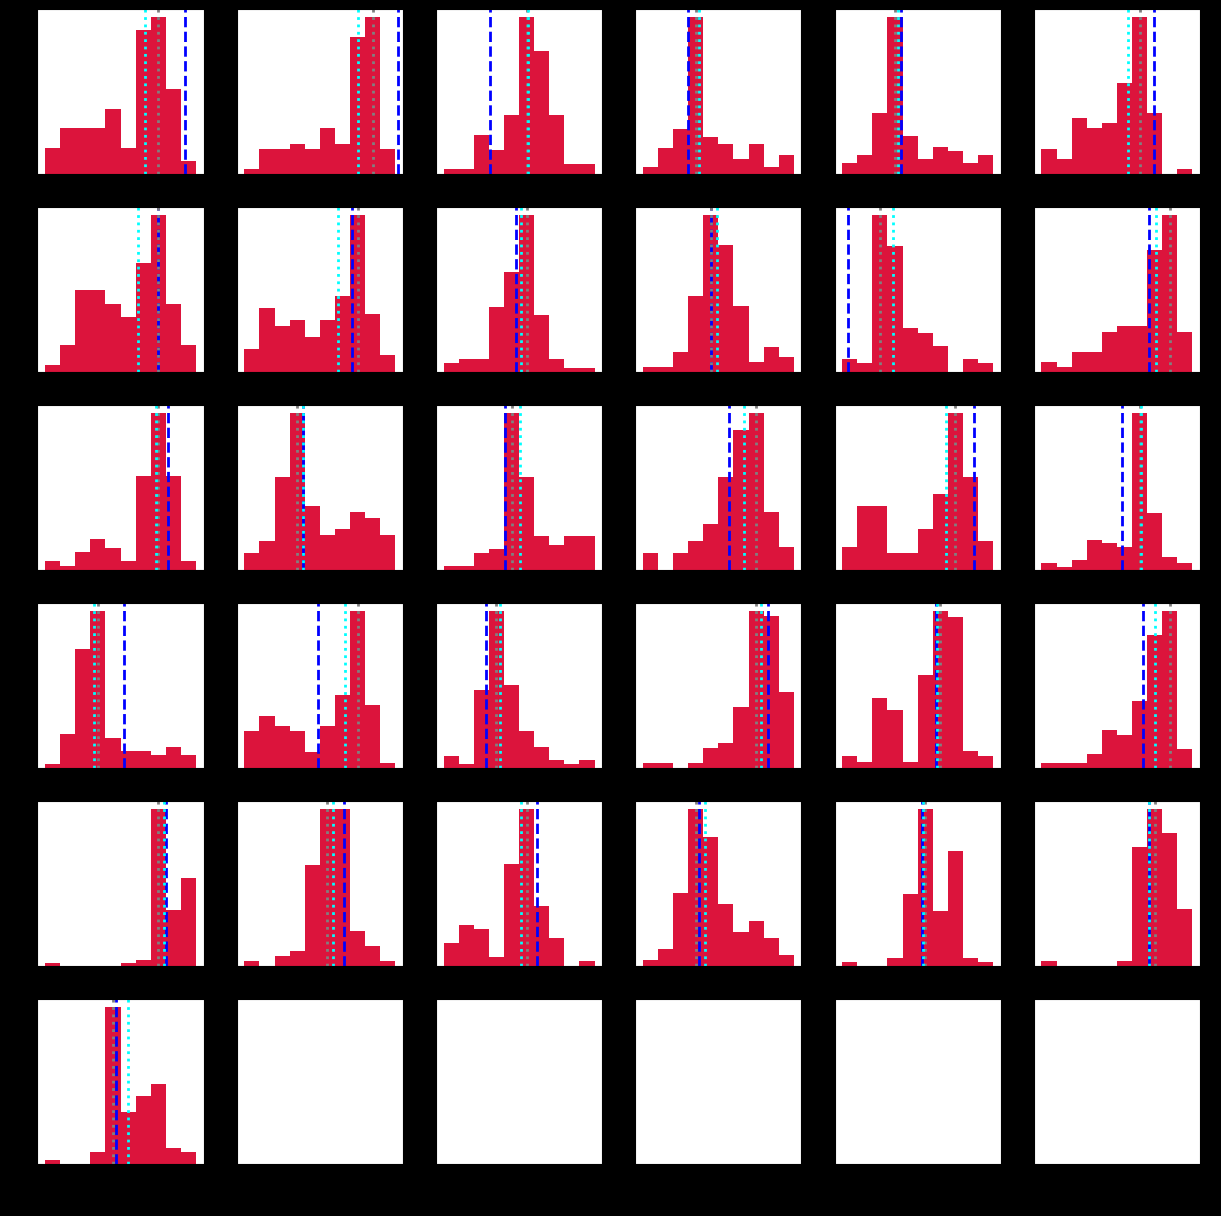

In [28]:
# Visulizing uncertainty estimates from multiple realizations
fig,axs = plt.subplots( 6,6,figsize=(15,15),facecolor="black" )
for k in range(df_train.shape[0]):
    row = k//6
    colm = k%6
    counts, bin_edges, patches = axs[row,colm].hist(  realizations_per_sample[ k ]["reals"],color="crimson" )
    imax = np.argmax(counts)
    midpoint = 0.5 * (bin_edges[imax] + bin_edges[imax + 1])
    axs[row,colm].axvline( realizations_per_sample[ k ]["actual"],ls="--",lw=2.0,color="blue" )
    axs[row,colm].axvline( midpoint,ls="dotted",lw=2.0,color="gray" )
    axs[row,colm].axvline( np.median( realizations_per_sample[ k ]["reals"] ),ls="dotted",lw=2.0,color="cyan" )

In [29]:
counts = [ ]
for percent_value in np.arange(0,1.1,0.1):
    count = 0
    outside_range=1-percent_value
    for k in range(df_train.shape[0]):
        if (realizations_per_sample[ k ]["actual"]>=np.quantile( realizations_per_sample[ k ]["reals"],outside_range/2 )) and (realizations_per_sample[ k ]["actual"]<=np.quantile( realizations_per_sample[ k ]["reals"],1-outside_range/2 )):
            count += 1
    counts.append( count/df_train.shape[0] )
counts = np.array(counts)

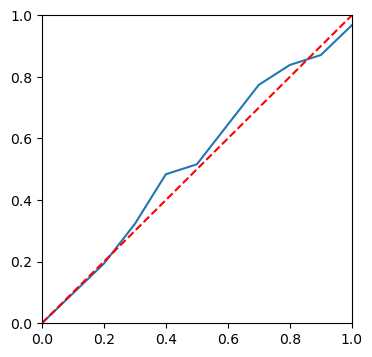

In [30]:
fig,ax = plt.subplots( figsize=(4,4) )
ax.plot( np.arange(0,1.1,0.1),counts )
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.add_line( Line2D( [0,1],[0,1],color="red",lw=1.5,ls="--" ) )

# Final predictions

In [34]:
# Preparing preproduction data for predictions
df_preproduction = pd.read_csv( "logs_preproduction.csv" )
df_preproduction["mean_perm"] = 0
for id in np.unique( df_preproduction["Well_ID"] ):
    print(np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["perm"] ))
    df_preproduction.loc[df_preproduction["Well_ID"]==id,"mean_perm"] = np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["perm"] )

# Adding log of permeability as feature to predict
df_preproduction["logperm"] = np.log( df_preproduction["mean_perm"] )

614.5193707165
1078.506667467619
936.0280205089524
1636.2010318947366
846.6214038333334
683.7977429293501
122.65067313336843
427.9245321080952
137.19931909204763
374.93761647785
286.17728327500004
433.69381494095234


/var/folders/jt/80yg0b7543l0_sx4zfq877t80000gn/T/ipykernel_3566/2592570587.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '614.5193707165' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_preproduction.loc[df_preproduction["Well_ID"]==id,"mean_perm"] = np.mean( df_preproduction[df_preproduction["Well_ID"]==id]["perm"] )


In [35]:
# Groping pre-production data by well ID
df_preproduction = df_preproduction.groupby("Well_ID", as_index=False).first(  )
df_preproduction.head(  )

,Well_ID,X,Y,Z,AI,SI,Vp,Vs,rho_b,rho_f,...,Ksat,G0,Gdry,Gsat,facies,phi,perm,GR,mean_perm,logperm
0,72,23,94,19,7197904.5,2875019.500,2857.923584,1141.524780,2.334913,1.073520,...,16.195187,13.098044,3.281906,3.281906,5.0,0.081892,30.410023,87.724987,614.519371,6.420840
1,73,57,142,19,6787758.5,3335389.250,2781.488525,1366.776245,2.440333,0.977868,...,12.801764,25.536600,4.558731,4.558731,3.0,0.120740,98.241755,51.590473,1078.506667,6.983333
2,74,80,61,19,8425695.0,3489587.250,3232.098633,1338.606445,2.606881,1.077363,...,21.004433,13.592002,4.671184,4.671184,6.0,0.041320,3.886722,95.822611,936.028021,6.841645
3,75,45,187,19,4282267.5,2015072.875,1945.088989,915.285278,2.201579,0.909153,...,5.870235,42.125225,1.844367,1.809800,2.0,0.256617,1040.215182,39.272246,1636.201032,7.400132
4,76,68,108,19,5828772.0,2514801.750,2473.237305,1072.350830,2.356738,1.029221,...,10.802470,21.961340,2.710099,2.710099,4.0,0.175637,307.481393,57.090879,846.621404,6.741254


In [38]:
# Making predictions with uncertainty estimates for pre-production data
realizations_per_sample = {  }
for i in range(df_preproduction.shape[0]):
    id = df_preproduction.iloc[i]["Well_ID"]
    Xinterest = df_preproduction.iloc[i]["logperm"]
    realizations_per_sample[ id ] = { "best_pred":0.0,"realizations":[  ] }
    for j in range(100):
        degree_rand = 3 #Tuned via resampling (see code above)
        X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.80 )
        model = LinearRegression(  ) #Selected via resampling (see code above)
        pipe = Pipeline( [('scaler', StandardScaler(  )), ('model', model)] )
        poly=PolynomialFeatures(degree=degree_rand,include_bias=True)
        poly_features=poly.fit_transform(X_train.reshape(-1,1))
        poly_test=poly.transform( Xinterest.reshape(-1,1) )
        pipe.fit(poly_features, y_train)
        ypred = pipe.predict( poly_test )[0]            
        realizations_per_sample[ id ]["realizations"].append( ypred )
    realizations_per_sample[ id ]["best_pred"] = np.median( realizations_per_sample[ id ]["realizations"] )

KeyError: 'reals'

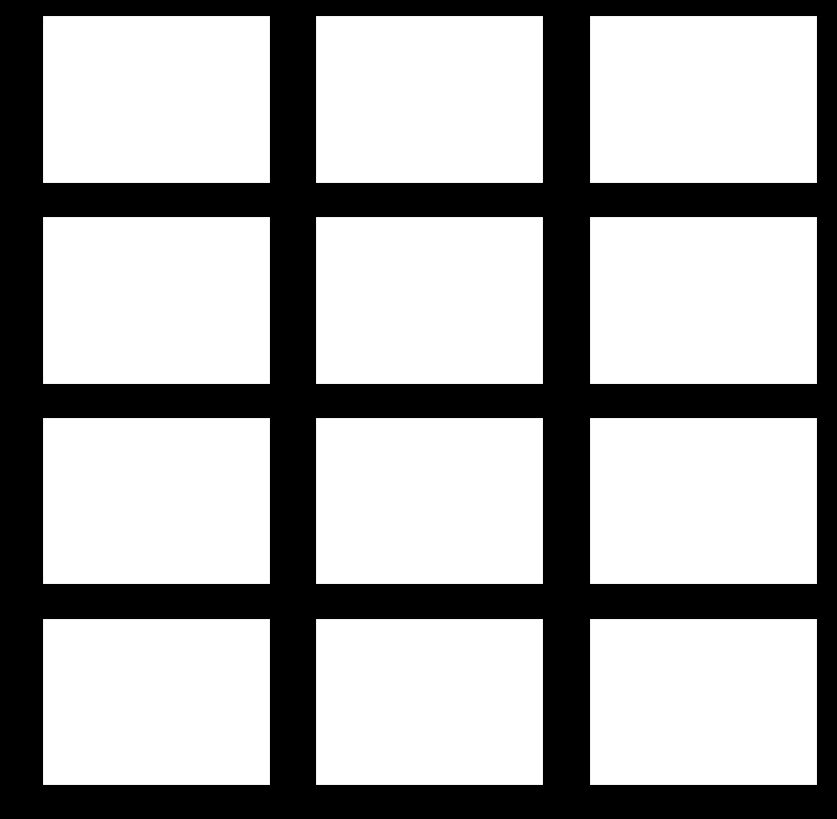

In [39]:
# Visualizing uncertainty estimates for pre-production data
fig,axs = plt.subplots( 4,3,figsize=(10,10),facecolor="black" )
for k in range(df_preproduction.shape[0]):
    row = k//3
    colm = k%4
    id = df_preproduction.iloc[i]["Well_ID"]
    counts, bin_edges, patches = axs[row,colm].hist(  realizations_per_sample[ id ]["reals"],color="crimson" )
    imax = np.argmax(counts)
    midpoint = 0.5 * (bin_edges[imax] + bin_edges[imax + 1])
    axs[row,colm].axvline( realizations_per_sample[ id ]["actual"],ls="--",lw=2.0,color="blue" )
    axs[row,colm].axvline( midpoint,ls="dotted",lw=2.0,color="gray" )
    axs[row,colm].axvline( np.median( realizations_per_sample[ id ]["reals"] ),ls="dotted",lw=2.0,color="cyan" )